In [83]:
import sys
sys.path.append('../')
from LOD_Brain.model import layers
from LOD_Brain.model import losses
from LOD_Brain.python_utils import select_colors_from_gt_slice, color
import tensorflow as tf
import nibabel as nib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def to_image(t1, segm=None,
           slices_to_display: int = 32,
           alpha: float = 0.3,
             title=''):
    """
    Function to visualize volumes. If the predicted volume is passed, compact (t1 + gt) in a single volume 

    :param t1: expected tensor of shape [1, x, y, z, 1]
    :param segm: expected tensor of shape [1, x, y, z, n_classes]
    :param n_slices_to_display: number of slices to display
    :param alpha: segm transparency
    
    Todo: move this function under `LOD_Brain.python_utils`
    """

    if segm is not None:
        t1_np = t1[0, :, :, :, 0]  #  
        seg_np = (np.argmax(segm[0, ...], axis=-1)).astype(np.uint8)

        # Rescale t1 into range [0, 255], type uint8
        t1_np -= np.min(t1_np)
        t1_np /= np.max(t1_np)
        t1_np = np.round(t1_np * 255).astype(np.uint8)
    
    fig = plt.figure(figsize=(15, slices_to_display//4))
    fig.suptitle(f'Axial Plane - {title}', x=0.5, y=0.98, size=25)
    step = 256 // slices_to_display
    for i in range(slices_to_display):
        ax = fig.add_subplot(slices_to_display//8,8,i+1)
        if segm is not None:
            # Give only labels present in 'i_slice'
            colors = select_colors_from_gt_slice(seg_np[:, i*step, :])

            # Create image, transpose (for a better visualisation), and stack
            i_image = color.label2rgb(label=seg_np[:, i*step, :],
                                      image=t1_np[:, i*step, :],
                                      kind='overlay',
                                      alpha=alpha,
                                      image_alpha=1,
                                      colors=colors)
            i_image = (i_image.transpose(1, 0, 2))[::-1, :, :]      # show in proper orientation
            i_image = np.round(i_image * 255).astype(np.uint8)      # cast and set the range [0, 255]
        else:
            i_image = t1[0, :, i*step, :, 0].transpose(1, 0)[::-1, :]
        ax.imshow(i_image, cmap='gray'
                 )
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    fig.tight_layout()
    fig.show()

# Load pretrained model 

In [4]:
weights_file = 'model.7im5hf6z.h5'

In [5]:
custom_objects = {"Plain": layers.Plain,
                  "BottleNeck": layers.BottleNeck,
                  "UpPlain": layers.UpPlain,
                  "UpBottleNeck": layers.UpBottleNeck,
                  "per_channel_dice_loss": losses.per_channel_dice_loss,
                  "tversky_metric": losses.tversky_metric,
                  "jaccard_metric": losses.jaccard_metric,
                  "compute_per_channel_dice": losses.compute_per_channel_dice
                  }
model = tf.keras.models.load_model(weights_file, custom_objects=custom_objects)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 25 0                                            
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 128, 128, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 896         max_pooling3d[0][0]              
__________________________________________________________________________________________________
plain (Plain)                   (None, 64, 64, 64, 6 22128       conv3d[0][0]                     
______________________________________________________________________________________________

# Sample data loading 

From nifti

In [10]:
i_x_path = './data/T1w_defaced_256/sub-Ra0928_ses-1_run-02_T1w_defaced_256iso.nii.gz'

# Load X (T1w) and Y (GT) volumes
i_X = nib.load(i_x_path)
i_X_vol = np.array(i_X.get_fdata()).astype(dtype='float32')
# z-score the volume before testing
i_X_vol = stats.zscore(i_X_vol, axis=None)
i_X_vol = np.expand_dims(i_X_vol, axis=[0, -1])

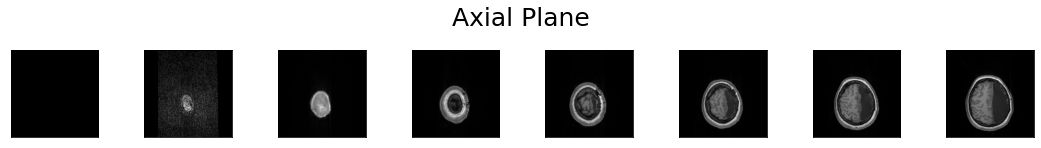

In [30]:
to_image(i_X_vol, slices_to_display=8)

# Extract segmentation

In [20]:
segm = model.predict(i_X_vol, verbose=False)

/home/mattias/.local/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


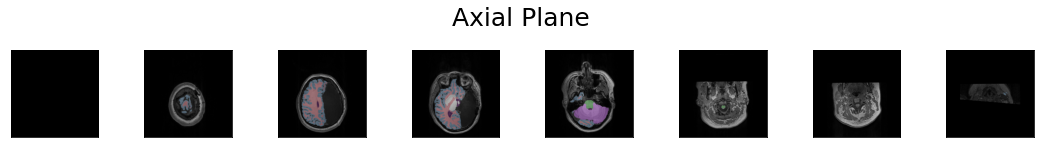

In [48]:
to_image(i_X_vol,  segm, slices_to_display=8)